In [6]:
!{sys.executable} -m pip install -v "opencv-python==4.5.1.48"
!{sys.executable} -m pip install matplotlib

Using pip 21.1.2 from d:\projects\put\computer-vision-project-2\venv\lib\site-packages\pip (python 3.7)
Non-user install because user site-packages disabled
Created temporary directory: C:\Users\aszcz\AppData\Local\Temp\pip-ephem-wheel-cache-2if85ugz
Created temporary directory: C:\Users\aszcz\AppData\Local\Temp\pip-req-tracker-sfrtzt2e
Initialized build tracking at C:\Users\aszcz\AppData\Local\Temp\pip-req-tracker-sfrtzt2e
Created build tracker: C:\Users\aszcz\AppData\Local\Temp\pip-req-tracker-sfrtzt2e
Entered build tracker: C:\Users\aszcz\AppData\Local\Temp\pip-req-tracker-sfrtzt2e
Created temporary directory: C:\Users\aszcz\AppData\Local\Temp\pip-install-w4trre_2
Created temporary directory: C:\Users\aszcz\AppData\Local\Temp\pip-unpack-92bh5v0w
Removed build tracker: 'C:\\Users\\aszcz\\AppData\\Local\\Temp\\pip-req-tracker-sfrtzt2e'


In [1]:
import cv2 as cv
from matplotlib import pyplot as plt

from src.pipeline_functions import straighten_page, remove_grid_lines


Load image

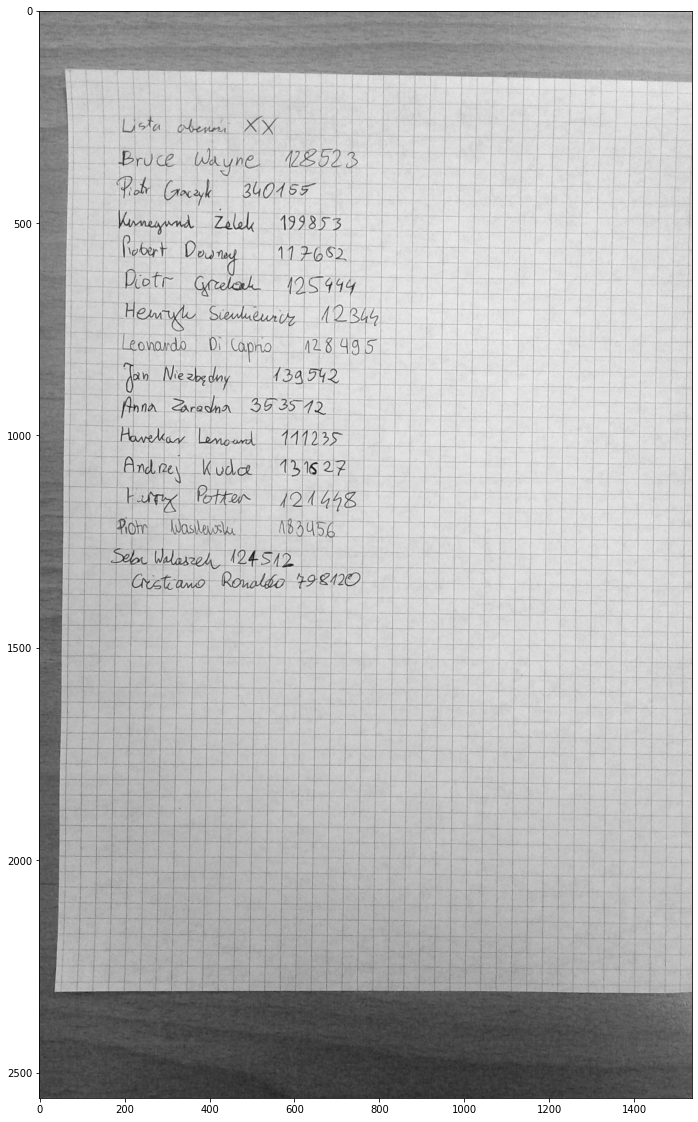

In [121]:
image = cv.imread('data/img_4.jpg', cv.IMREAD_GRAYSCALE)

plt.figure(figsize=(20, 20))
plt.imshow(image, cmap='gray')
plt.show()

Straighten image

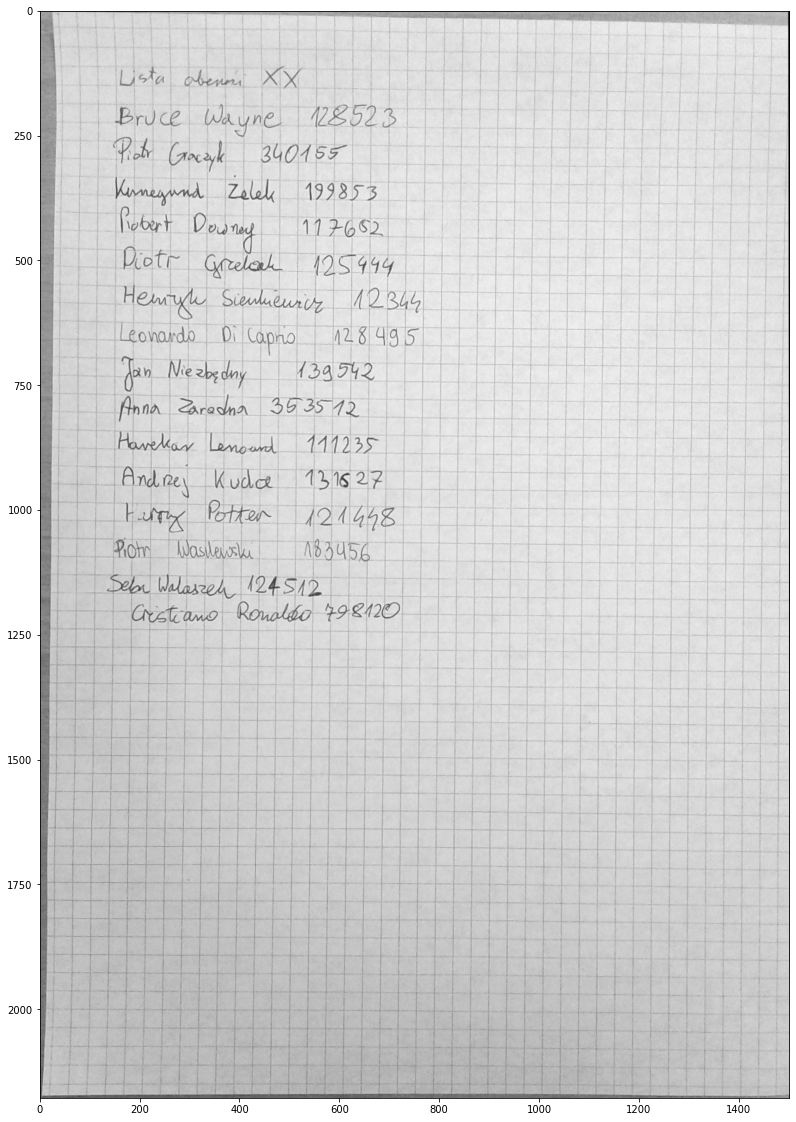

In [122]:
image_straightened = straighten_page(image)

plt.figure(figsize=(20, 20))
plt.imshow(image_straightened, cmap='gray')
plt.show()


Remove grid lines

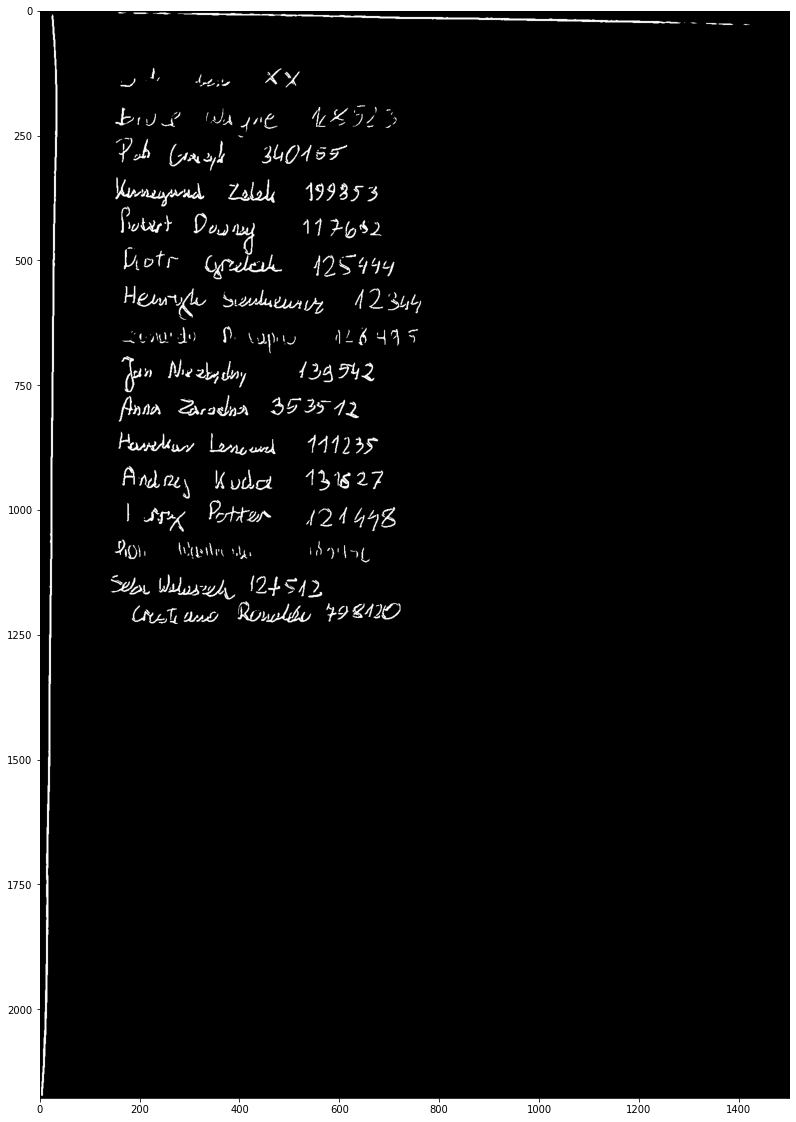

In [123]:
image_no_grid = remove_grid_lines(image_straightened)

plt.figure(figsize=(20, 20))
plt.imshow(image_no_grid, cmap='gray')
plt.show()

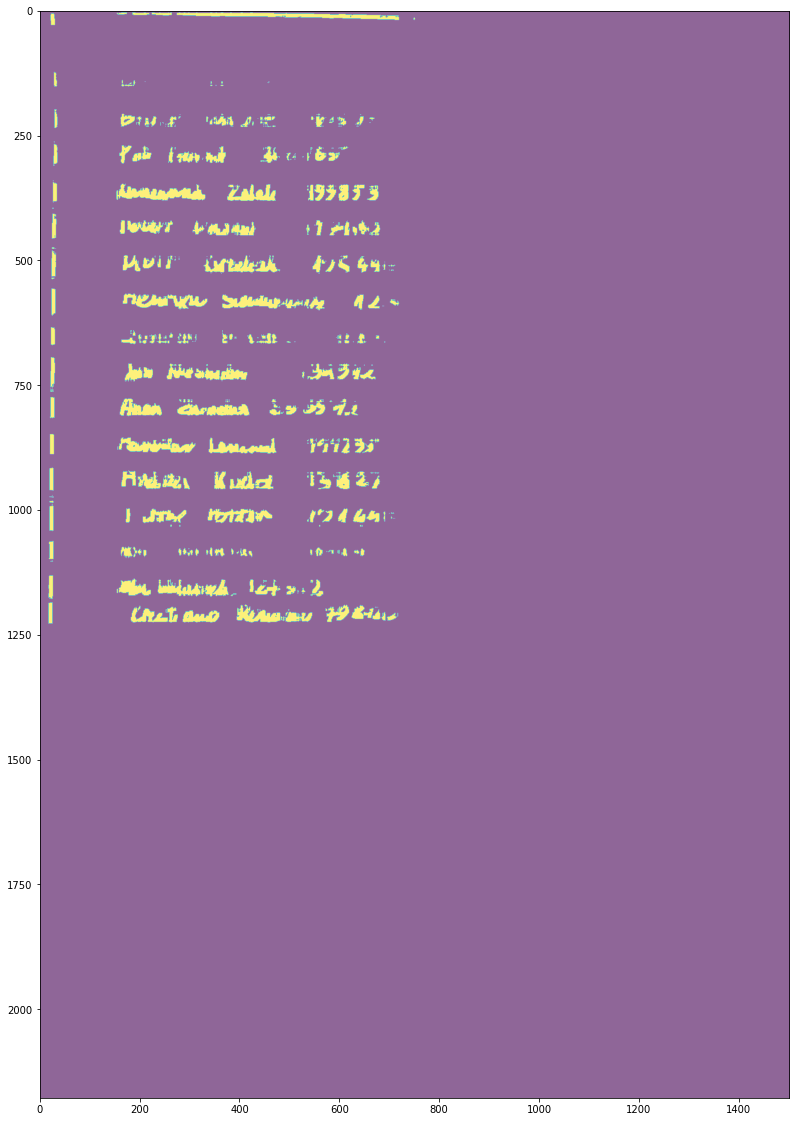

In [124]:
import numpy as np
from sklearn.cluster import KMeans
from scipy import ndimage

plt.figure(figsize=(20, 20))
row_pixels = np.sum(image_no_grid, axis=1)
col_pixels = np.sum(image_no_grid, axis=0)


height, width = image_no_grid.shape
mask_rows = np.array([[r for _ in range(width)] for r in row_pixels])
mask_cols = np.array([col_pixels for _ in range(height)])
mask_comp = mask_rows * mask_cols * ndimage.convolve(image_no_grid, [
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
])

c = KMeans(2).fit_predict(mask_comp.reshape(-1, 1))

mask_clusters = c.reshape(mask_comp.shape)
plt.imshow(mask_clusters, alpha=0.6)

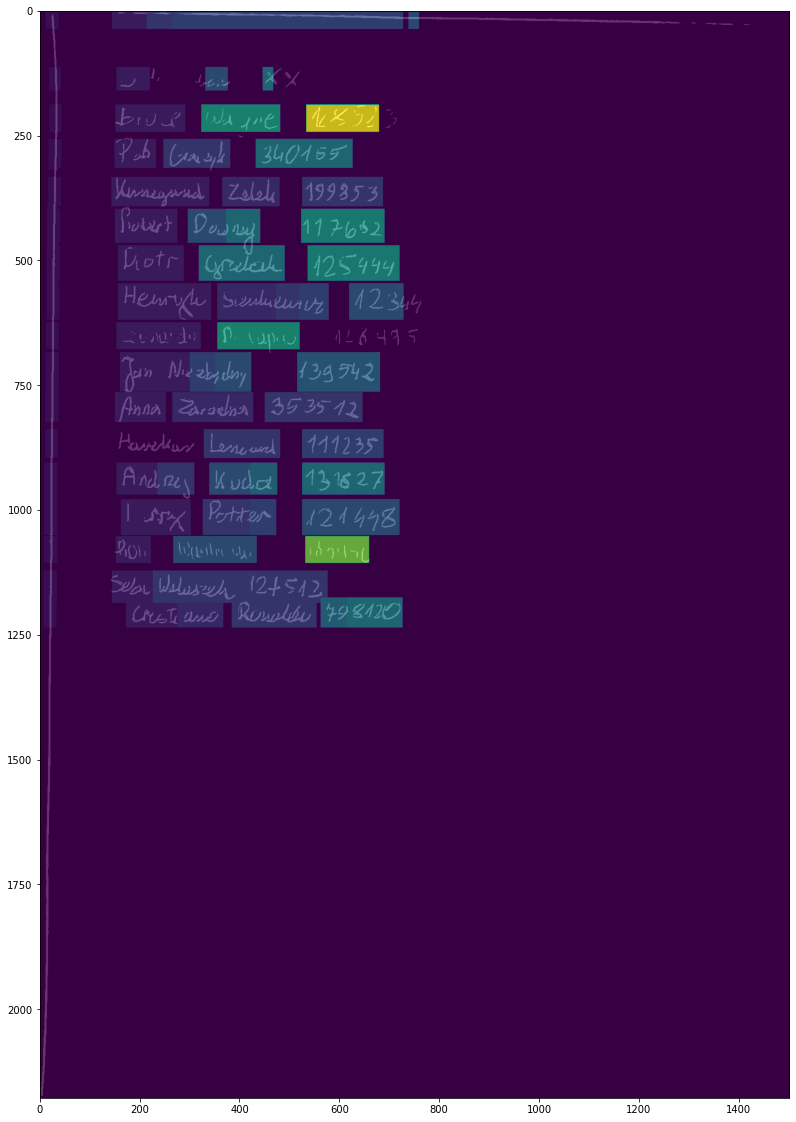

In [146]:
from collections import Counter
from skimage.morphology import dilation, square
plt.figure(figsize=(20, 20))

background_cluster = Counter(mask_clusters.flatten()).most_common(1)[0][0]
marker_cluster = 1 - background_cluster

def find_groups(matrix):
    group, marked = [], []
    for num, dim in enumerate(matrix):
        if np.any(dim == marker_cluster):
            group.append(num)
        elif len(group):
            marked.append(group)
            group = []

    lines_mask = np.zeros_like(matrix)
    for i, g in enumerate(marked, 1):
        a, b = g[0], g[-1]
        lines_mask[a:b] = i

    return lines_mask, marked


# segments_per_rows = []
rows, marked_rows = find_groups(mask_clusters)
for g in marked_rows:
    row_segments = []

    a, b = g[0], g[-1]
    clipped = mask_clusters[a:b]
    cols, marked_cols = find_groups(clipped.T)
    if len(marked_cols):
        try:
            breaks = [(col_beg[0] - col_end[-1]) for col_end, col_beg in zip(marked_cols, marked_cols[1:])]
            connection_cols_treshold = np.mean(breaks)

            for col_a, col_b in zip(marked_cols, marked_cols[1:]):
                segments_distance = col_b[0] - col_a[-1]
                segment_a_width = col_a[-1] - col_a[0]
                segment_b_width = col_b[-1] - col_b[0]

                if segments_distance < 30 and (segment_a_width < 30 or segment_b_width < 30):
                    group_value = cols[col_a[-1] - 1][0]
                    cols[col_a[-1]:col_b[-1]+1] = group_value
                    # trzeba aktualizowac przedzialy i powinno dzialca

            rows[a:b] = cols.T
            # informacje o segmencie
            # row_segments.append({
            #     'height': ,
            #     'width': ,
            #     'left_top_corner': ()
            # })
        except Exception as e:
            print(e)
            rows[a:b] = background_cluster
    else:
        rows[a:b] = background_cluster

    # segments_per_rows.append(row_segments)

# dodajemy te obiekty, które nie sa przypisane, a sa w poblizu
rows = dilation(rows, square(20))
relief_img = image_no_grid.copy()
relief_img[rows != 0] = 0

plt.imshow(image_no_grid, cmap='gray')
plt.imshow(rows, alpha=0.8)